In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tabulate import tabulate
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
dt=pd.read_csv('Biobank.csv')
dt.shape

(10000, 14)

# Project : Analysis of Multimorbidity relationship with composite lifestyle
**Statement** : 
This project aims to investigate not only the association between composite lifestyle factors (such as smoking, alcohol consumption, physical activity) and multimorbidity (Dementia, MI, Stroke) but also to explore the impact of individual lifestyle factors and their combinations on the occurrence of multimorbidity. 

**Research Question** : 
1. How do composite lifestyle factors such as smoking, alcohol consumption, and physical activity influence the risk of multimorbidity, specifically the co-occurrence of dementia, myocardial infarction (MI), and stroke in adults?
2. Is there an association between the accumulation of unhealthy lifestyle factors and an increased likelihood of multimorbidity?

**Steps** :
1. Data Cleaning

2. Building Life style score matrix and Mutilmorbidity score matrix.

3. Exploratory Data Analysis and Statistical Testing

4. Logistic Regression Model of the Impact of Lifestyle score on Multimorbidity

5. Predictive Modeling

## Data Explanation
<img src="Data Explanation.png">

## Data Observing and Cleaning

Combined with the data explanation, I understand that only townsend_deprivation_index, bmi_0, cholesterol_0, and MET_activity should be continuous value whereas others are not. So we should change the data type of those whom are falsely assigned, eg, ID, ethnicity_group, etc.  And keep the value of the object features that are bring less information to the final result to be replaced by the mode value.

In [13]:
dt.head()

,ID,age,sex,ethnicity_group,education_college_university_0,townsend_deprivation_index,bmi_0,cholesterol_0,MET_activity,smoking_status_0,alcohol_status_0,dementia_all_outcome,MI_all_outcome,stroke_all_outcome
0,1405382,45,M,1,0,-1.604790,27.8376,6.483,4434.0,0,2,0,0,0
1,4951100,60,M,1,0,-3.030690,30.3461,5.657,7758.0,1,2,0,0,0
2,1905838,61,F,3,1,-0.494598,22.7585,4.382,1762.5,0,2,0,0,0
3,5789006,51,M,1,0,-2.666960,30.4153,4.489,2886.0,1,2,0,0,0
4,3446339,46,M,1,0,-0.109900,22.6736,6.061,2900.0,0,2,0,0,0


In [14]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10000 non-null  int64  
 1   age                             10000 non-null  int64  
 2   sex                             10000 non-null  object 
 3   ethnicity_group                 10000 non-null  int64  
 4   education_college_university_0  10000 non-null  int64  
 5   townsend_deprivation_index      10000 non-null  float64
 6   bmi_0                           10000 non-null  float64
 7   cholesterol_0                   10000 non-null  float64
 8   MET_activity                    10000 non-null  float64
 9   smoking_status_0                10000 non-null  int64  
 10  alcohol_status_0                10000 non-null  int64  
 11  dementia_all_outcome            10000 non-null  int64  
 12  MI_all_outcome                  1

In [15]:
cat_features=['ID','sex','ethnicity_group','education_college_university_0','smoking_status_0','alcohol_status_0',
          'dementia_all_outcome','MI_all_outcome','stroke_all_outcome']
for col in cat_features:
    dt[col]=dt[col].astype('category')

In [16]:
dt.describe()

,age,townsend_deprivation_index,bmi_0,cholesterol_0,MET_activity
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,56.295000,-1.407212,27.293288,5.697140,2640.81551
std,8.130374,3.034013,4.727089,1.159595,2678.40509
min,40.000000,-6.258260,12.646300,2.074000,0.00000
25%,50.000000,-3.691205,24.052400,4.917000,780.00000
50%,57.000000,-2.196720,26.624450,5.646500,1775.00000
75%,63.000000,0.307542,29.617400,6.441000,3546.00000
max,70.000000,9.892430,68.129900,10.748000,19278.00000


In [18]:
#Checking the missing value
dt.isna().sum()

ID                                0
age                               0
sex                               0
ethnicity_group                   0
education_college_university_0    0
townsend_deprivation_index        0
bmi_0                             0
cholesterol_0                     0
MET_activity                      0
smoking_status_0                  0
alcohol_status_0                  0
dementia_all_outcome              0
MI_all_outcome                    0
stroke_all_outcome                0
dtype: int64

In [19]:
#Checking the duplicates total
dt.duplicated().sum()

0

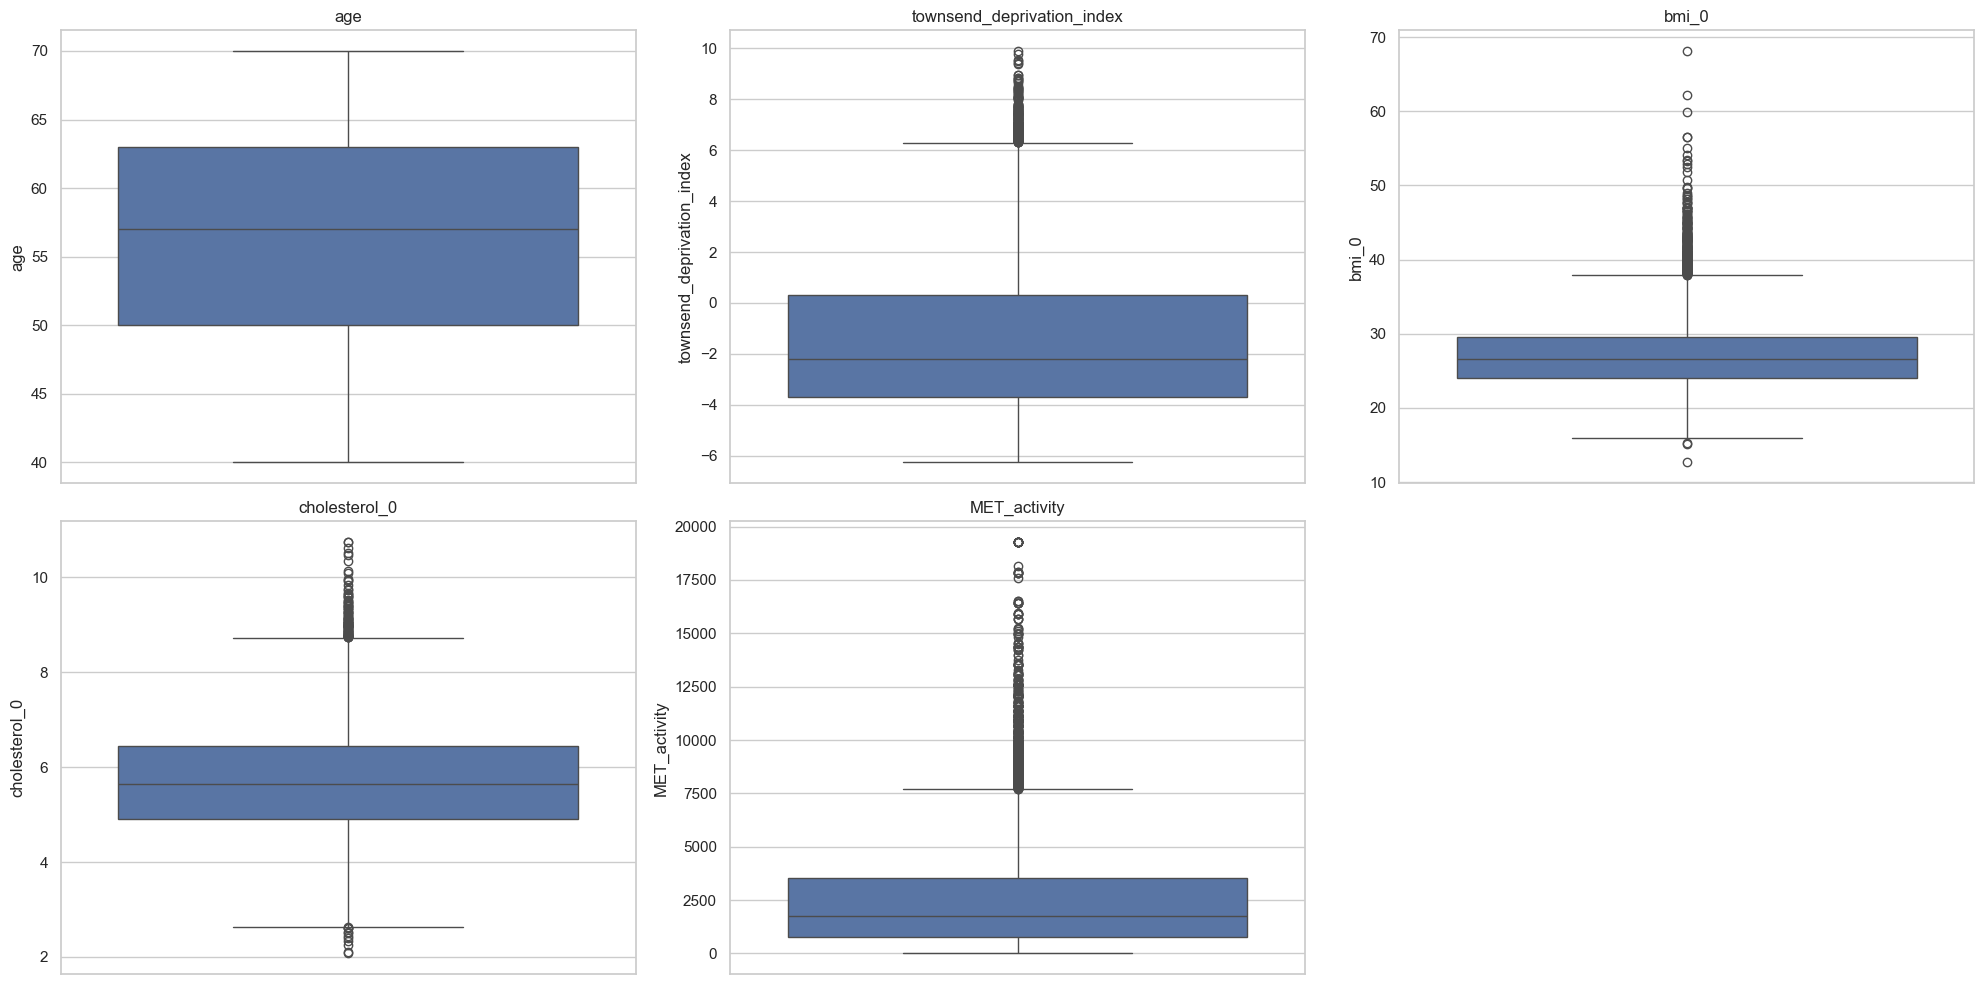

In [20]:
#Extracting numerical feature to visualize and see the distribution
num_features=['age','townsend_deprivation_index','bmi_0','cholesterol_0','MET_activity']
dt_num=dt[num_features]
plt.figure(figsize=(20,10))
sb.set_theme(style="whitegrid")

for i, feature in enumerate(dt_num,1):
    plt.subplot(2,3,i)
    sb.boxplot(y=dt_num[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [21]:
def get_mode(v):
    counts={}
    for i in v:
        counts[i]=counts.get(i,0)+1
    max_counts=max(counts.values())
    mode=[key for key,value in counts.items() if value==max_counts]
    return mode[0] if len(mode)==1 else mode

In [9]:
dt.loc[dt['ethnicity_group'].isin([997, 999]), 'ethnicity_group'] = get_mode(dt['ethnicity_group'])
dt.loc[dt['smoking_status_0'].isin([9]), 'smoking_status_0'] = get_mode(dt['smoking_status_0'])
dt.loc[dt['alcohol_status_0'].isin([9]), 'alcohol_status_0'] = get_mode(dt['alcohol_status_0'])

/Users/chungkaichou/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/chungkaichou/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/chungkaichou/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adop

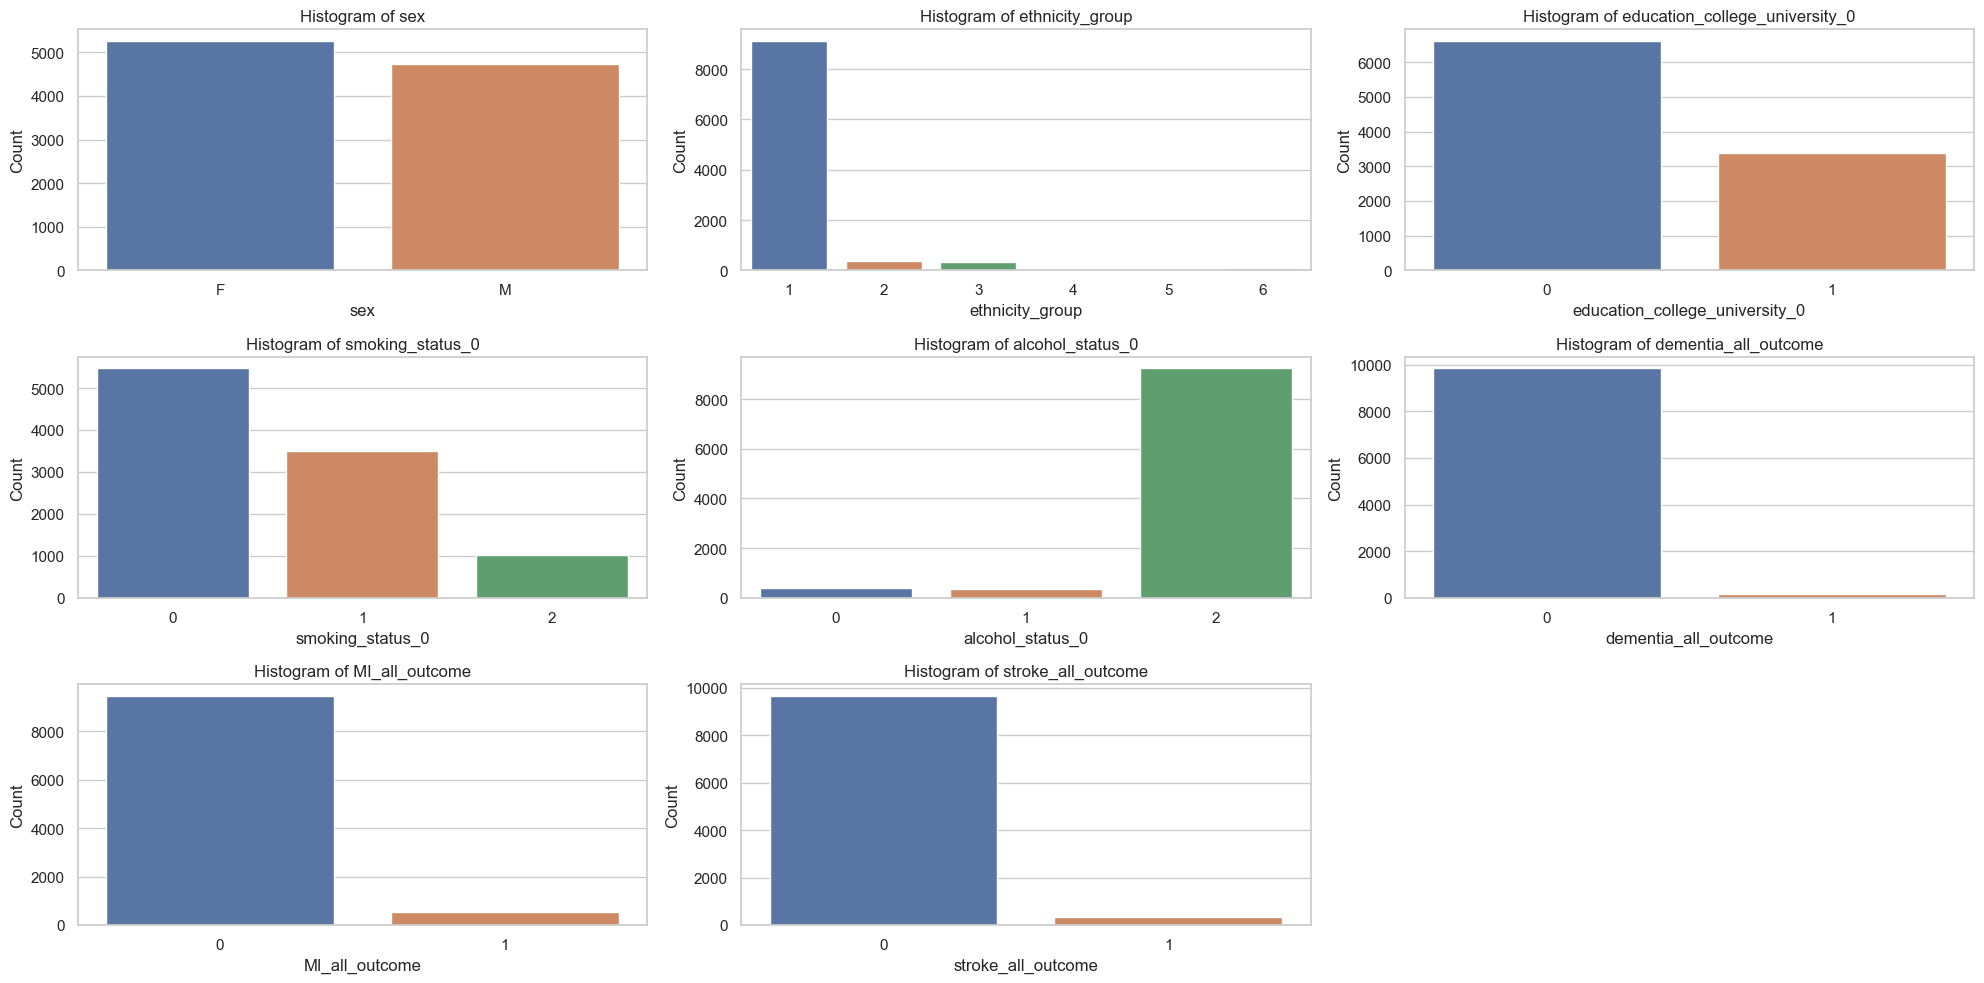

In [10]:
plt.figure(figsize=(20,10))
nrows=3
ncols=3
for i, col in enumerate(cat_features,start=1):
    plt.subplot(nrows, ncols,i)
    sb.countplot(x=col,data=dt)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


## Martix Building
**Lifestyle Composite Score Matrix Building** :
In this part, I get the concept from a article at Journal of Multimorbidity & Comorbidity that study “the Relationship between multimorbidity and composite lifestyle status in Shenzhen, China”. In the article, the researchers cut the life factor into three levels, transformed into composite score, and calculated the score by using an algorithm that summarized the sub-scores from multiple life style factors and use this composite score to understand its relation with multimorbidity, which is define as two or more chronic diseases coexisting in a single person. So my calculation is to separate each factor into three levels: **Healthy(2pt)**, **Normal(1pt)**, and **Bad(0pt)**.

**BMI**:
BMI<=18.5(Underweight): Normal(1pt)
BMI>18.5 and <=25(Normal): Healthy(2pt)
BMI>25 and <=30(Overweight): Normal(1pt)
BMI>30(Obese): Bad(0pt)

**Activity**:
MET_Activity>=150: Healthy(2pt)
MET_Activity<150: Normal(1pt)
MET_Actovoty=0: Bad(0pt)

**Alcohol Status**:
Alcohol=0(No Habit): Healthy(2pt)
Alcohol=1(Past Habit): Normal(1pt)
Alcohol=2(Current Habit): Bad(0pt)

**Smoking Status**:
Smoking=0(No Habit): Healthy(2pt)
Smoking=1(Past Habit): Normal(1pt)
Smoking=2(Current Habit): Bad(0pt)

For Multimorbidity calculation, I just simply sum up all three conditions outcome: Dementia, Myocardial Infarction (heart attack), and Stroke Outcome. If the total of three conditions over 2, then it should be consider as multimorbidity.

In [11]:
# Lifestyle Factor Metrix Building 
def lifestyle_calculator(bmi,activity,alcohol,smoking):
    bmi_score=2 if 18.5 <= bmi < 25 else 1 if bmi <= 18.5 or 25<=bmi<30 else 0
    activity_score= 2 if activity>=150 else 1 if activity>0 else 0
    alcohol_score= 2 if alcohol==0 else 1 if alcohol==1 else 0
    smoking_score= 2 if smoking==0 else 1 if smoking==1 else 0
    return bmi_score+activity_score+alcohol_score+smoking_score

<Axes: xlabel='lifestyle_score'>

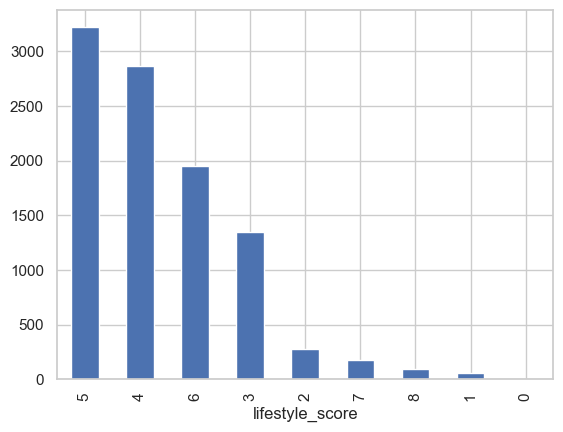

In [12]:
dt['lifestyle_score'] = dt.apply(lambda row: lifestyle_calculator(row['bmi_0'], row['MET_activity'], row['alcohol_status_0'], row['smoking_status_0']), axis=1)
dt['lifestyle_score'].value_counts().plot(kind='bar')

In [13]:
# Multimorbidity Metrix Building
dt['dementia']=dt['dementia_all_outcome'].astype(int)
dt['stroke']=dt['stroke_all_outcome'].astype(int)
dt['MI']=dt['MI_all_outcome'].astype(int)
dt['multimorbidity']=dt['dementia']+dt['stroke']+dt['MI']
dt['multimorbidity'].value_counts()

multimorbidity
0    9099
1     813
2      79
3       9
Name: count, dtype: int64

In [14]:
# pick the variables for the next exploratory analysis
dt_final=dt.drop(columns=['ID','townsend_deprivation_index','dementia_all_outcome','MI_all_outcome','stroke_all_outcome','cholesterol_0','dementia','stroke','MI'])
dt_final.head()

,age,sex,ethnicity_group,education_college_university_0,bmi_0,MET_activity,smoking_status_0,alcohol_status_0,lifestyle_score,multimorbidity
0,45,M,1,0,27.8376,4434.0,0,2,5,0
1,60,M,1,0,30.3461,7758.0,1,2,3,0
2,61,F,3,1,22.7585,1762.5,0,2,6,0
3,51,M,1,0,30.4153,2886.0,1,2,3,0
4,46,M,1,0,22.6736,2900.0,0,2,6,0


In [15]:
bins=[0,39,49,59,np.inf]
labels=['<40','40-49','50-59','60+']
dt_final['age_group']=pd.cut(dt_final['age'],bins=bins,labels=labels,include_lowest=True)

In [16]:
dt_final['multimorbidity_pre_abs']=(dt_final['multimorbidity']>=2).astype(int)

In [17]:
#male and female mean and standard deviation 
age_male = dt_final[dt_final['sex'] == 'M']['age'].agg(['mean', 'std'])
age_female = dt_final[dt_final['sex'] == 'F']['age'].agg(['mean', 'std'])
#number of patients by disease and sex
morbidity_counts = dt_final.groupby(['sex', 'multimorbidity']).size().unstack(fill_value=0)
morbidity_percentage = morbidity_counts.div(morbidity_counts.sum(axis=1), axis=0) * 100
#format for morbidity
format_perc_mmb_m = ['{:.1f}'.format(i) for i in morbidity_percentage.loc['M']]
format_perc_mmb_f = ['{:.1f}'.format(i) for i in morbidity_percentage.loc['F']]
#number of patients by ethnicity and sex
ethnicity_counts = dt_final.groupby(['sex', 'ethnicity_group']).size().unstack(fill_value=0)
ethnicity_percentage = ethnicity_counts.div(ethnicity_counts.sum(axis=1), axis=0) * 100

#number of patients by education and sex
education_counts = dt_final.groupby(['sex','education_college_university_0']).size().unstack()
education_percentage = education_counts.div(education_counts.sum(axis=1), axis=0)*100

#Ethnicity names
ethnicity_group_names = {
    1: "White",
    2: "Mixed",
    3: "Asian or Asian British",
    4: "Black or Black British",
    5: "Chinese",
    6: "Other ethnic group"
}

education_group_names = {
    0:'High School',
    1:'College'
}
table_dt = [['Age: mean(SD)', f"{age_male['mean']:.1f} ({age_male['std']:.1f})",
            f"{age_female['mean']:.1f} ({age_female['std']:.1f})"],
['Patients by number of diseases: n (%)', '', '']]

for i in range(len(morbidity_percentage.columns)):
    row = [f"{i} disease" if i == 1 else f"{i} diseases"]
    row.extend([format_perc_mmb_m[i], format_perc_mmb_f[i]])
    table_dt.append(row)

table_dt.append(['Ethnicity Group:', '', ''])
for i, name in ethnicity_group_names.items():
    row = [name]
    row.extend([f"{ethnicity_percentage.loc['M', i]:.1f}", f"{ethnicity_percentage.loc['F', i]:.1f}"])
    table_dt.append(row)
    
table_dt.append(['Education Group:','',''])
for i, name in education_group_names.items():
    row= [name]
    row.extend([f"{education_percentage.loc['M',i]:.1f}", f"{education_percentage.loc['F',i]:.1f}"])
    table_dt.append(row)

print(tabulate(table_dt, headers=['Characteristics', 'Male (n = 5262)', 'Female (n = 4738)'], tablefmt='pipe'))

| Characteristics                       | Male (n = 5262)   | Female (n = 4738)   |
|:--------------------------------------|:------------------|:--------------------|
| Age: mean(SD)                         | 56.7 (8.2)        | 55.9 (8.0)          |
| Patients by number of diseases: n (%) |                   |                     |
| 0 diseases                            | 87.4              | 94.2                |
| 1 disease                             | 11.3              | 5.3                 |
| 2 diseases                            | 1.2               | 0.4                 |
| 3 diseases                            | 0.1               | 0.1                 |
| Ethnicity Group:                      |                   |                     |
| White                                 | 91.9              | 90.6                |
| Mixed                                 | 3.6               | 3.6                 |
| Asian or Asian British                | 2.8               | 3.7           

/var/folders/dr/05g6dmcd47v9mvnt25smv94h0000gn/T/ipykernel_2587/2397088997.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  morbidity_counts = dt_final.groupby(['sex', 'multimorbidity']).size().unstack(fill_value=0)
/var/folders/dr/05g6dmcd47v9mvnt25smv94h0000gn/T/ipykernel_2587/2397088997.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ethnicity_counts = dt_final.groupby(['sex', 'ethnicity_group']).size().unstack(fill_value=0)
/var/folders/dr/05g6dmcd47v9mvnt25smv94h0000gn/T/ipykernel_2587/2397088997.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

### Gender And Multimorbidity

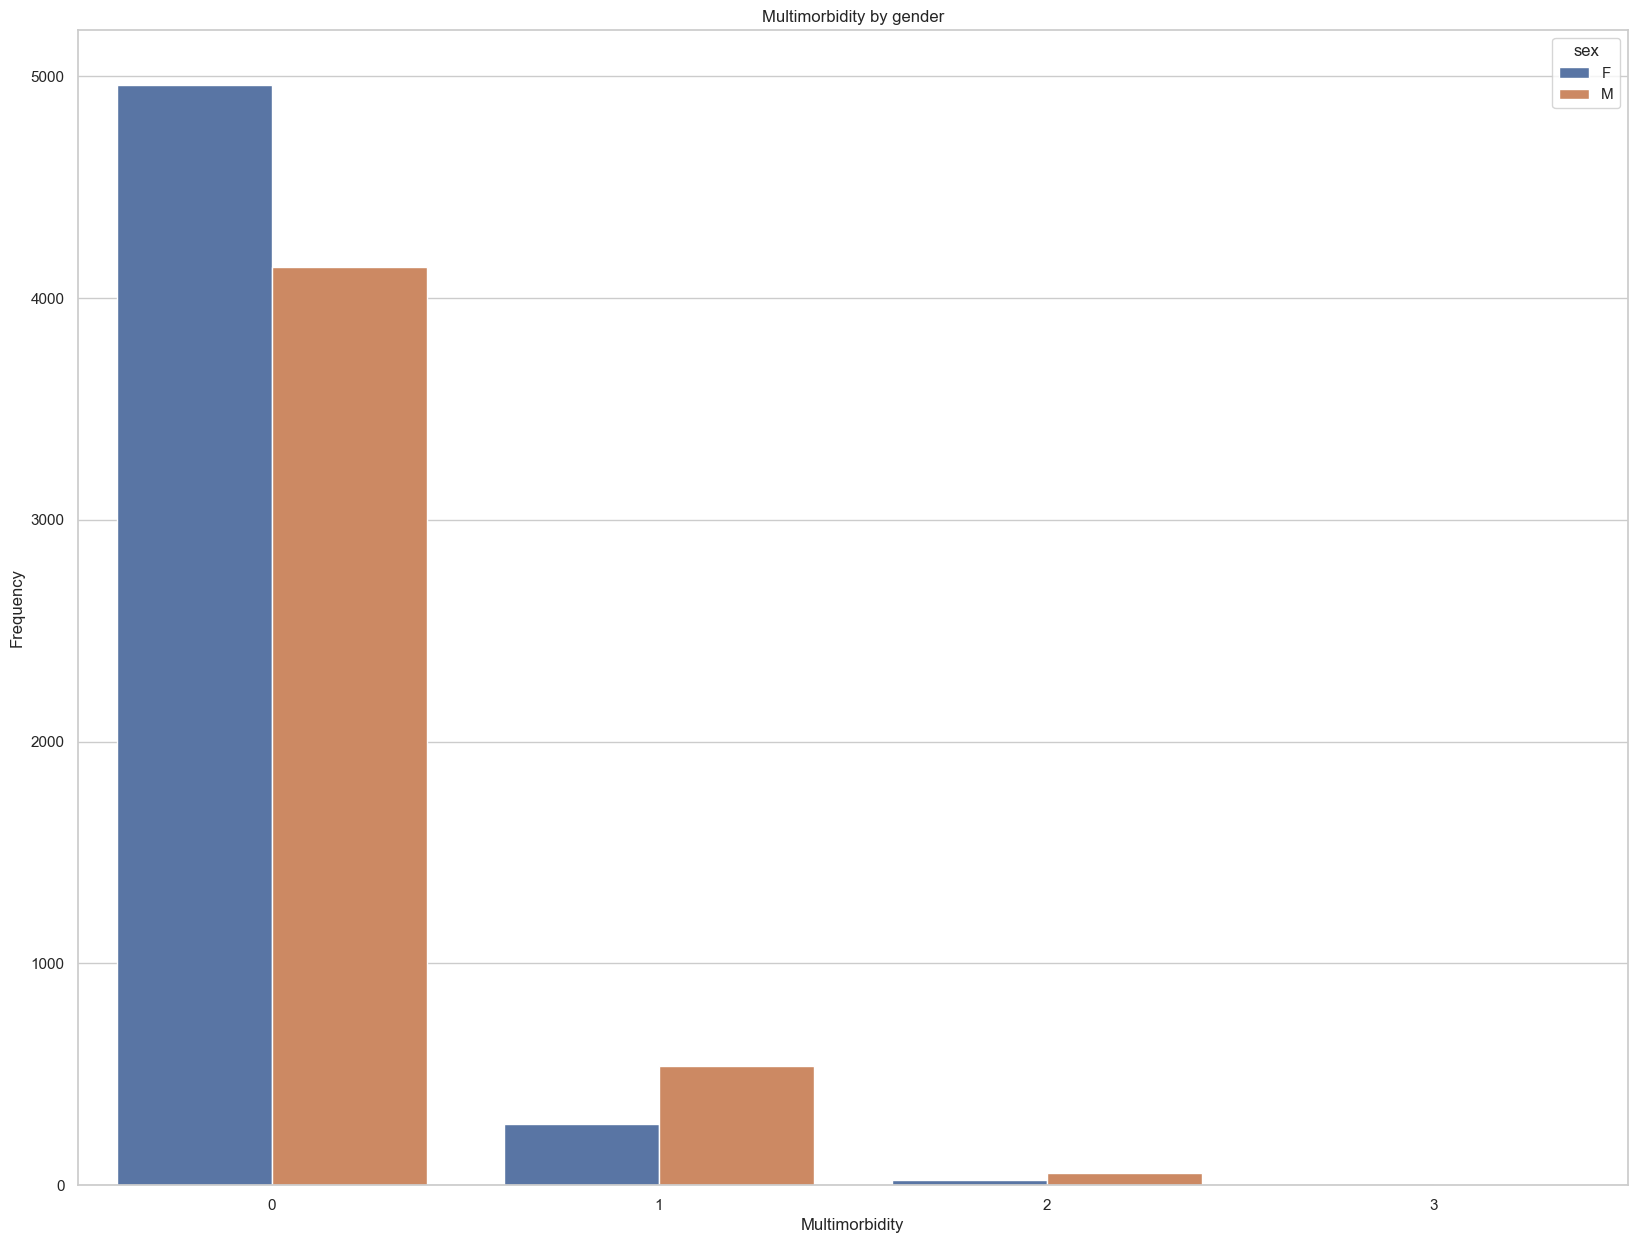

In [18]:
plt.figure(figsize=(20,15))
sb.countplot(x='multimorbidity',hue='sex',data=dt_final)
plt.title('Multimorbidity by gender')
plt.xlabel('Multimorbidity')
plt.ylabel('Frequency')
plt.show()

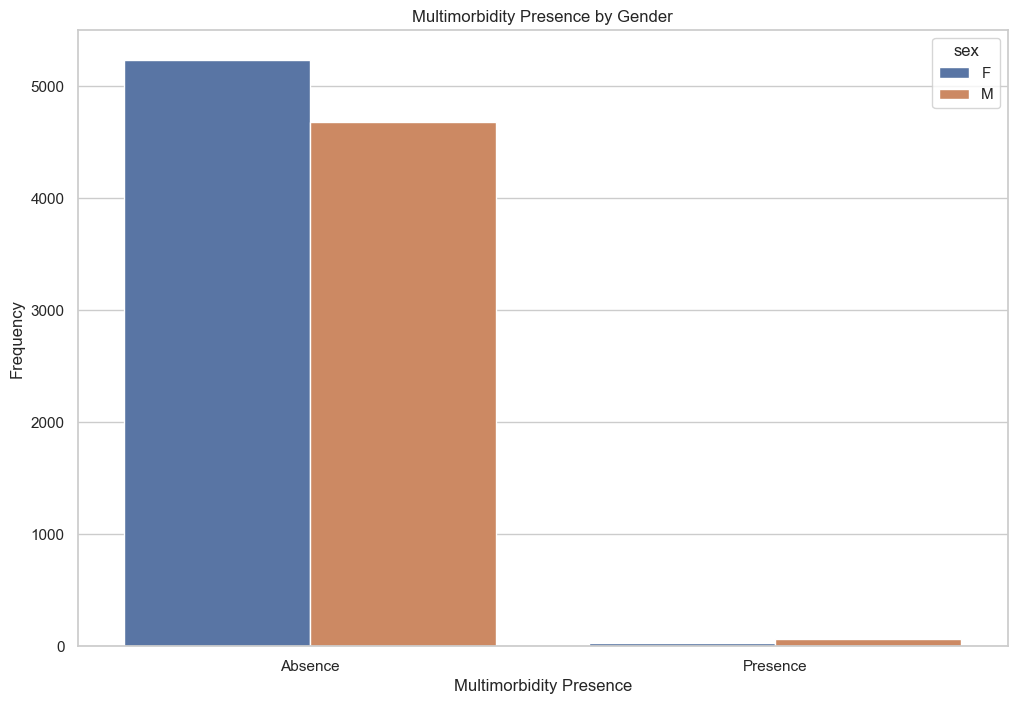

In [19]:
plt.figure(figsize=(12,8))
sb.countplot(x='multimorbidity_pre_abs',hue='sex',data=dt_final)
plt.title('Multimorbidity Presence by Gender')
plt.xlabel('Multimorbidity Presence')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['Absence', 'Presence'])
plt.show()

In [20]:
sex_mmb_table=pd.crosstab(dt_final['sex'],dt_final['multimorbidity'])
chi2,p,dof,ex=chi2_contingency(sex_mmb_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 144.40441227400134
P-value: 4.243140769278219e-31


Given the extreme small p-value, we can conclude that there's significant difference in the occurrence of multimorbidiy between male and female groups, meaning that the sex feature might be associated with the multimorbidity. And from the visualization results we can find the male group is actually more likelihood to get multimorbidity than female group.

### Age and Multimorbidity

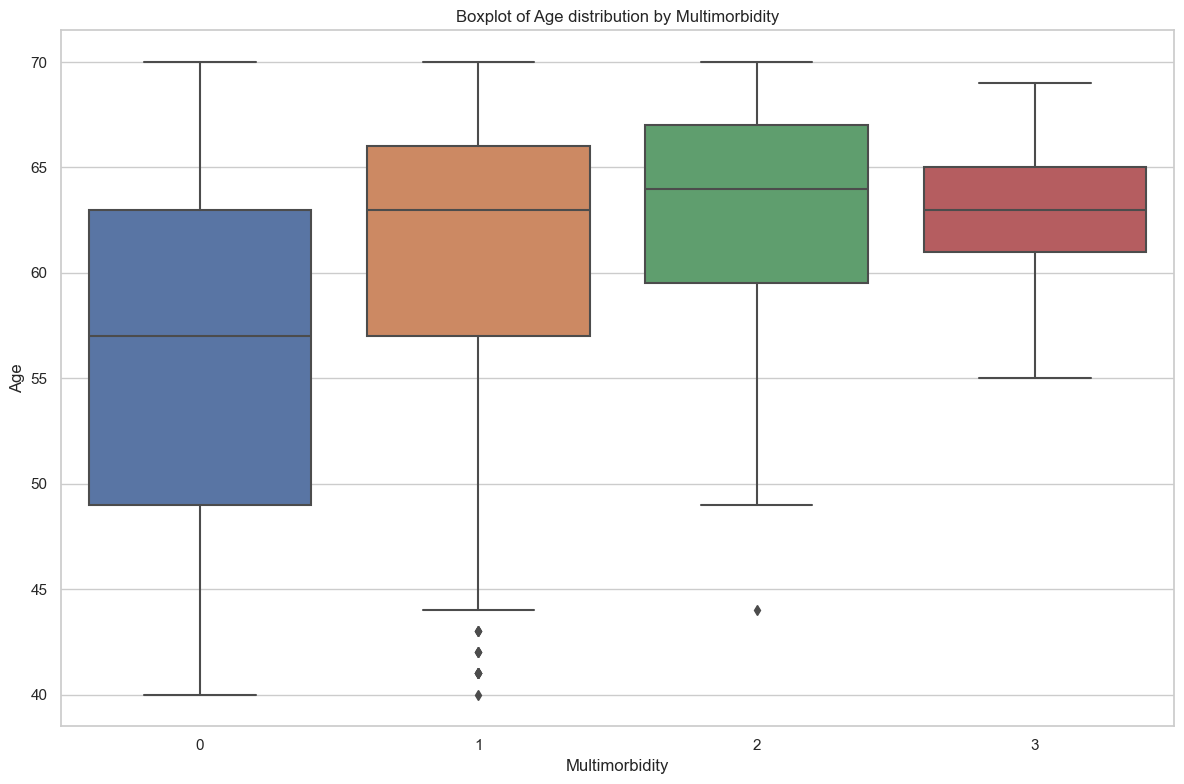

In [21]:
plt.figure(figsize=(12,8))
sb.boxplot(x='multimorbidity',y='age',data=dt_final)
plt.title('Boxplot of Age distribution by Multimorbidity')
plt.xlabel('Multimorbidity')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

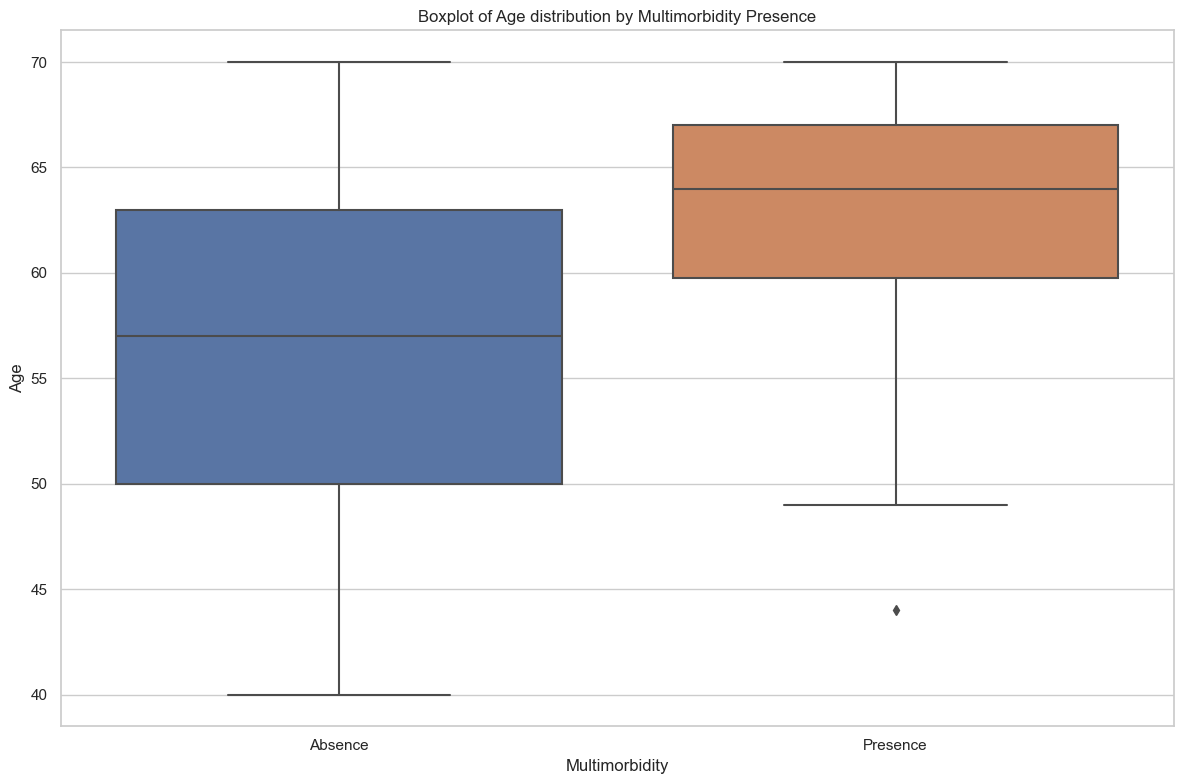

In [22]:
plt.figure(figsize=(12,8))
sb.boxplot(x='multimorbidity_pre_abs',y='age',data=dt_final)
plt.title('Boxplot of Age distribution by Multimorbidity Presence')
plt.xlabel('Multimorbidity')
plt.ylabel('Age')
plt.xticks(ticks=[0, 1], labels=['Absence', 'Presence'])
plt.tight_layout()
plt.show()

In [23]:
age_withmmb=dt_final[dt_final['multimorbidity_pre_abs']==1]['age']
age_withoutmmb=dt_final[dt_final['multimorbidity_pre_abs']==0]['age']
t_stat,p_value=ttest_ind(age_withmmb,age_withoutmmb)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 7.395190458255141
P-value: 1.5254181245743797e-13


From the graph and the statistical test result, we can conclude that age is statistically significant impact on multimorbidity, meaning that people older has higher likelihood to show multimorbidity than those younger or in the other way around that people with multimorbidity tend to be older than those without.

### Ethnicity group with Multimorbidity

In [24]:
dt_final['ethnicity_group']=dt_final['ethnicity_group'].astype(str)
dt_final['multimorbidity']=dt_final['multimorbidity'].astype(str)
dt_final['multimorbidity_pre_abs']=dt_final['multimorbidity_pre_abs'].astype(str)

In [1]:
plt.figure(figsize=(12,8))
sb.countplot(x=dt_final['ethnicity_group'],hue=dt_final['multimorbidity_pre_abs'])
plt.title('Boxplot of Ethnicity distribution by Multimorbidity')
plt.xlabel('Ethnicity/Multimorbidity')
plt.ylabel('Frequency')
plt.xticks(ticks=[0,1,2,3,4,5], labels=['White','Mixed','Asian','Black','Chinese','Other'])
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

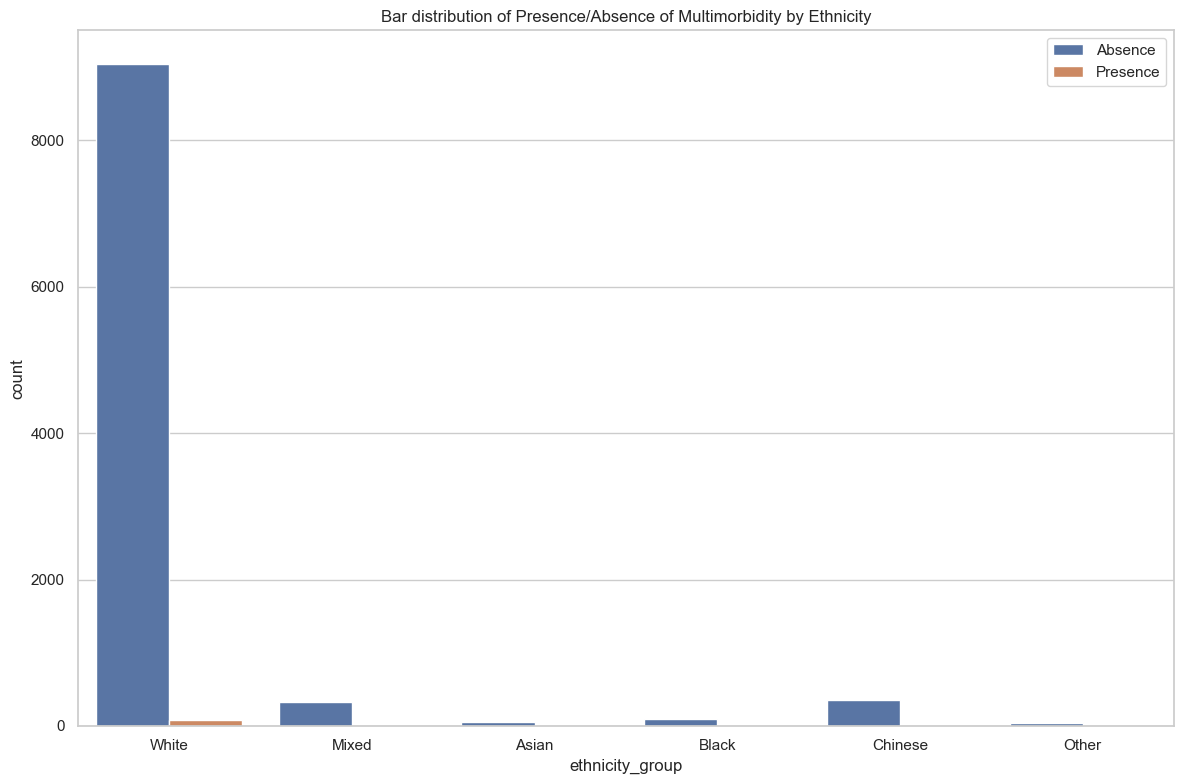

In [26]:
plt.figure(figsize=(12,8))
sb.countplot(x='ethnicity_group',hue='multimorbidity_pre_abs',data=dt_final)
plt.title('Bar distribution of Presence/Absence of Multimorbidity by Ethnicity')
plt.xticks(ticks=[0, 1,2,3,4,5],labels=['White','Mixed','Asian','Black','Chinese','Other'])
plt.legend(labels=['Absence','Presence'])
plt.tight_layout()
plt.show()

In [27]:
eth_mmb_table=pd.crosstab(dt_final['ethnicity_group'],dt_final['multimorbidity'])
chi2,p,dof,ex=chi2_contingency(eth_mmb_table)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 18.102536358550175
P-value: 0.25731330159254284


Given the result from statistical Chi-Square test, we failed to reject the null hypothesis that there's no association between ethnicity group and multimorbidity, meaning that variation in the presence of multimorbidity is probably not associated in a systematic difference.

### BMI And Multimorbidity

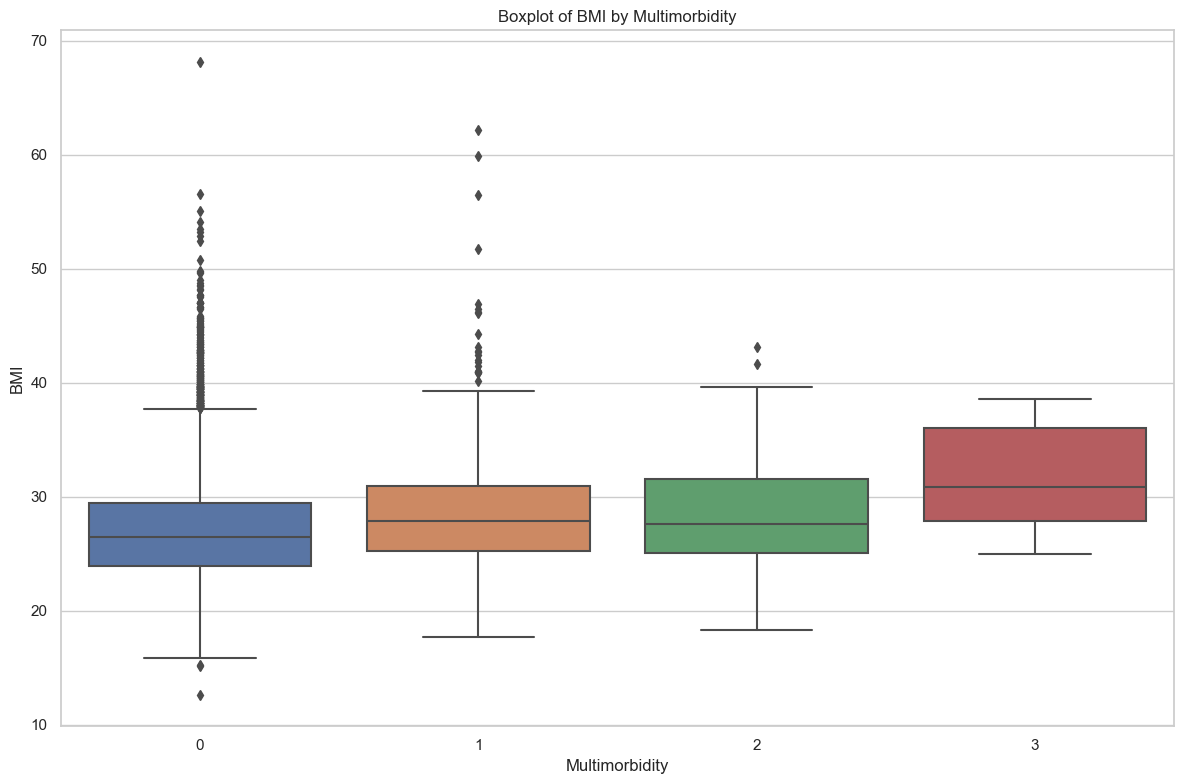

In [28]:
plt.figure(figsize=(12,8))
sb.boxplot(x='multimorbidity',y='bmi_0',data=dt_final)
plt.title('Boxplot of BMI by Multimorbidity')
plt.xlabel('Multimorbidity')
plt.ylabel('BMI')
plt.tight_layout()
plt.show()

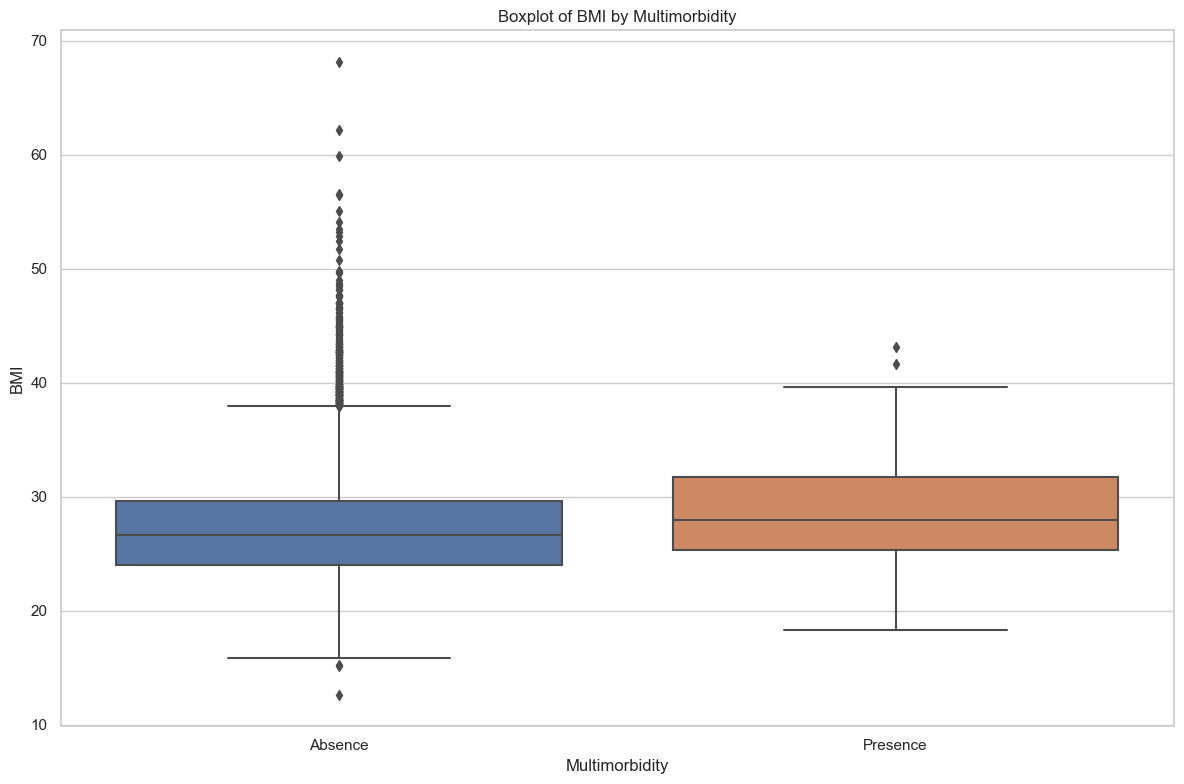

In [29]:
plt.figure(figsize=(12,8))
sb.boxplot(x='multimorbidity_pre_abs',y='bmi_0',data=dt_final)
plt.title('Boxplot of BMI by Multimorbidity')
plt.xlabel('Multimorbidity')
plt.ylabel('BMI')
plt.xticks(ticks=[0, 1],labels=['Absence','Presence'])
plt.tight_layout()
plt.show()

In [30]:
bmi_withmmb=dt_final[dt_final['multimorbidity_pre_abs']==1]['bmi_0']
bmi_withoutmmb=dt_final[dt_final['multimorbidity_pre_abs']==0]['bmi_0']
t_stat,p_value=ttest_ind(bmi_withmmb,bmi_withoutmmb)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: nan
P-value: nan


By the results of the statistical test, we can reject the null hypothesis that there's no significant difference in BMI between people with multimorbidity and those without, indicating that people with multimorbidity might have higher bmi than those without.

### Alcohol And Multimorbidity

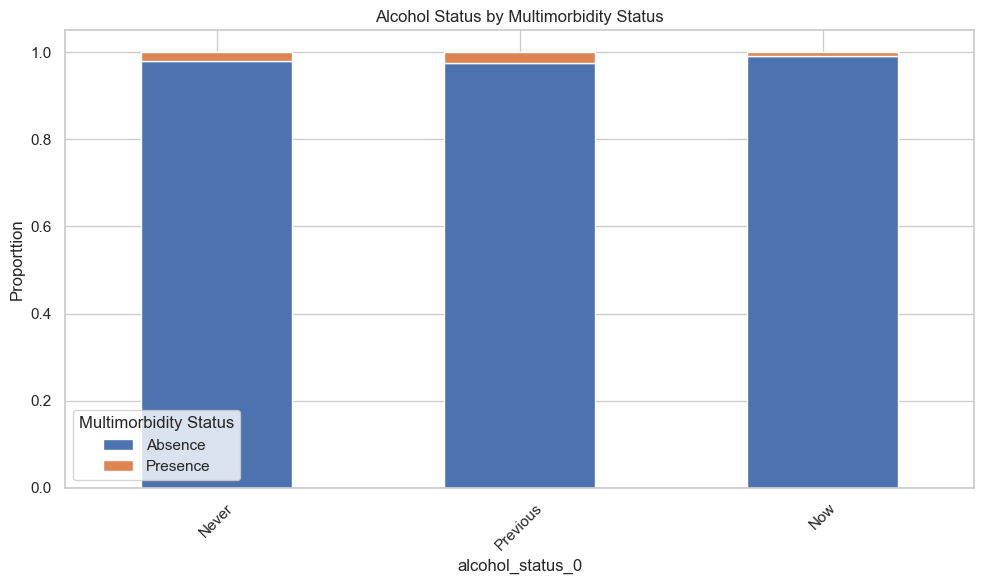

In [31]:
alcohol_tab=pd.crosstab(dt_final['alcohol_status_0'],dt_final['multimorbidity_pre_abs'],normalize='index')
alcohol_tab.plot(kind='bar',stacked=True,figsize=(10,6))
plt.title('Alcohol Status by Multimorbidity Status')
plt.ylabel('Proporttion')
plt.xticks(ticks=[0, 1,2], labels=['Never', 'Previous','Now'],rotation=45)
plt.legend(title='Multimorbidity Status',labels=['Absence','Presence'])
plt.tight_layout()
plt.show()

In [32]:
chi2, p_val, dof, expected = chi2_contingency(alcohol_tab)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 0.009219816760847932
P-value: 0.25731330159254284


From the statistical test result, we cannot reject the null hypothesis that there's no significant association between alcohol status and multimorbidity status.

### Smoking and Multimorbidity

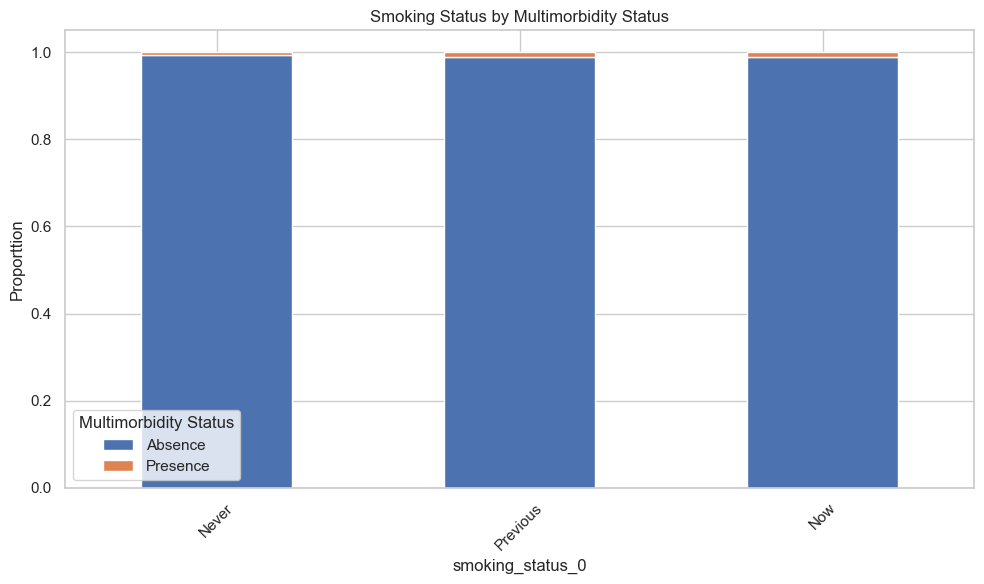

In [33]:
smoking_tab=pd.crosstab(dt_final['smoking_status_0'],dt_final['multimorbidity_pre_abs'],normalize='index')
smoking_tab.plot(kind='bar',stacked=True,figsize=(10,6))
plt.title('Smoking Status by Multimorbidity Status')
plt.ylabel('Proporttion')
plt.xticks(ticks=[0, 1,2], labels=['Never', 'Previous','Now'],rotation=45)
plt.legend(title='Multimorbidity Status',labels=['Absence','Presence'])
plt.tight_layout()
plt.show()

In [34]:
chi2, p_val, dof, expected = chi2_contingency(smoking_tab)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 0.0007836426474430265
P-value: 0.25731330159254284


Also from the statistical test result, we cannot reject the null hypothesis that there’s no significant association between alcohol status and multimorbidity status.

### MET and Multimorbidity



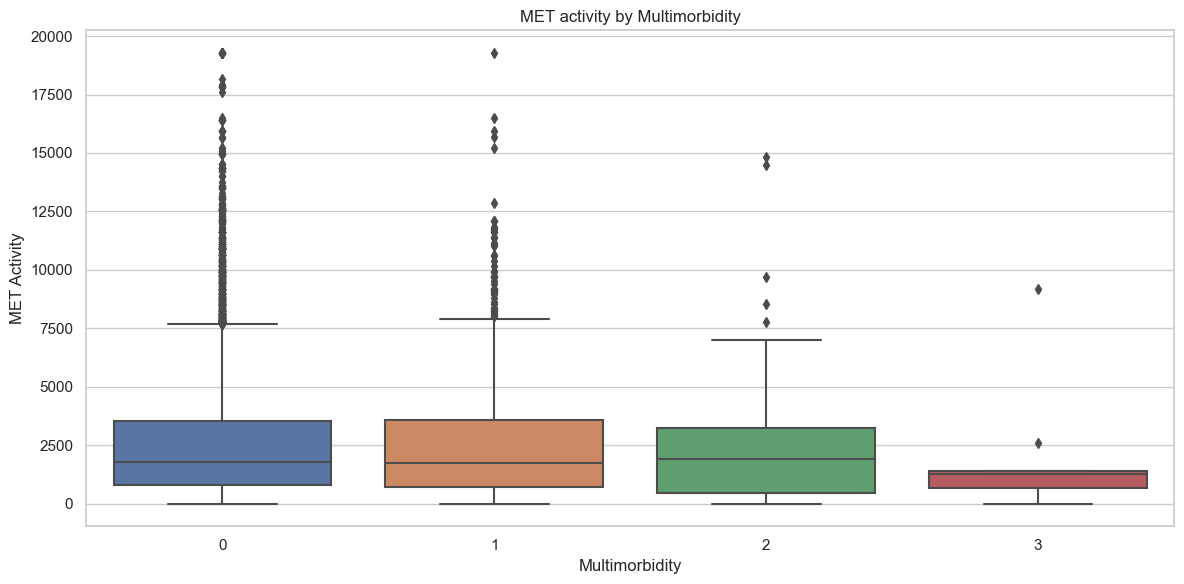

In [35]:
plt.figure(figsize=(12,6))
sb.boxplot(x='multimorbidity',y='MET_activity',data=dt_final)
plt.title("MET activity by Multimorbidity")
plt.xlabel('Multimorbidity')
plt.ylabel('MET Activity')
plt.tight_layout()
plt.show()

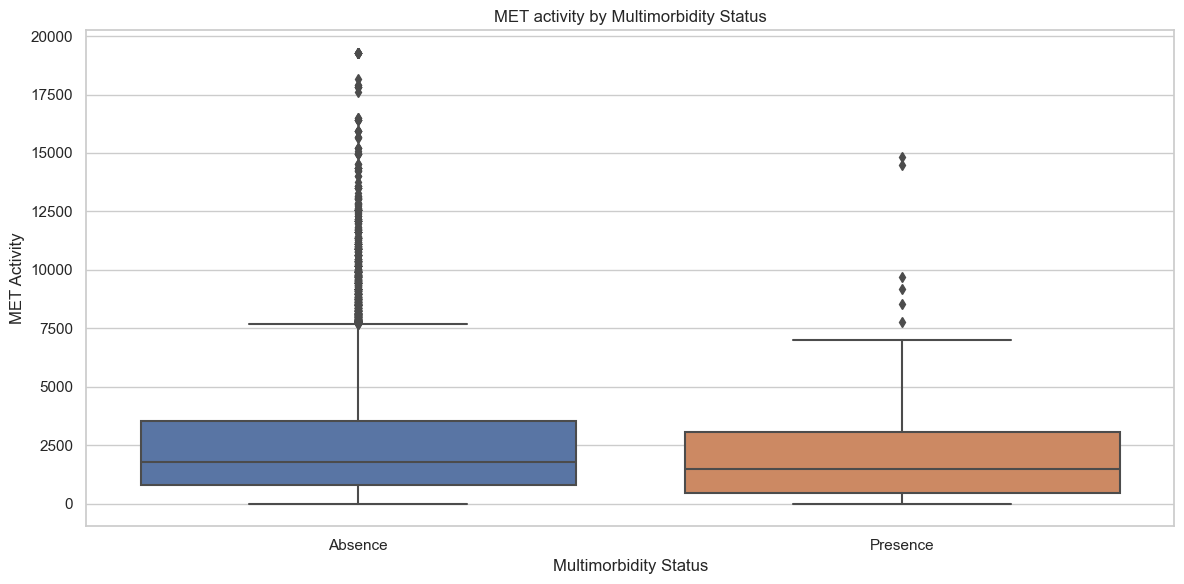

In [36]:
plt.figure(figsize=(12,6))
sb.boxplot(x='multimorbidity_pre_abs',y='MET_activity',data=dt_final)
plt.title("MET activity by Multimorbidity Status")
plt.xlabel('Multimorbidity Status')
plt.ylabel('MET Activity')
plt.xticks(ticks=[0, 1], labels=['Absence','Presence'])
plt.tight_layout()
plt.show()

In [37]:
met_withmmb=dt_final[dt_final['multimorbidity_pre_abs']==1]['MET_activity']
met_withoutmmb=dt_final[dt_final['multimorbidity_pre_abs']==0]['MET_activity']
t_stat,p_value=ttest_ind(met_withmmb,met_withoutmmb)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: nan
P-value: nan


The statistical test result telling us that we cannot reject the null hypothesis that there's no siginificant difference between two groups in MET activity time, meaning that people with multimorbidity and those without are no different in MET activity time.

In [51]:
#Correlation relation
col_to_correlation=['age','bmi_0','MET_activity','education_college_university_0','smoking_status_0','alcohol_status_0','lifestyle_score','multimorbidity']
dt_corr=dt_final[col_to_correlation]
correlation_matrix=dt_corr.corr()
correlation_matrix

,age,bmi_0,MET_activity,education_college_university_0,smoking_status_0,alcohol_status_0,lifestyle_score,multimorbidity
age,1.000000,0.029821,-0.001337,-0.127977,0.040451,-0.025558,-0.035680,0.174912
bmi_0,0.029821,1.000000,-0.085523,-0.110707,0.023439,-0.048861,-0.568541,0.085217
MET_activity,-0.001337,-0.085523,1.000000,-0.101565,0.009460,0.000226,0.092313,-0.003540
education_college_university_0,-0.127977,-0.110707,-0.101565,1.000000,-0.081986,0.035985,0.105628,-0.075529
smoking_status_0,0.040451,0.023439,0.009460,-0.081986,1.000000,0.061661,-0.627213,0.060497
alcohol_status_0,-0.025558,-0.048861,0.000226,0.035985,0.061661,1.000000,-0.363136,-0.045957
lifestyle_score,-0.035680,-0.568541,0.092313,0.105628,-0.627213,-0.363136,1.000000,-0.081279
multimorbidity,0.174912,0.085217,-0.003540,-0.075529,0.060497,-0.045957,-0.081279,1.000000


<Axes: >

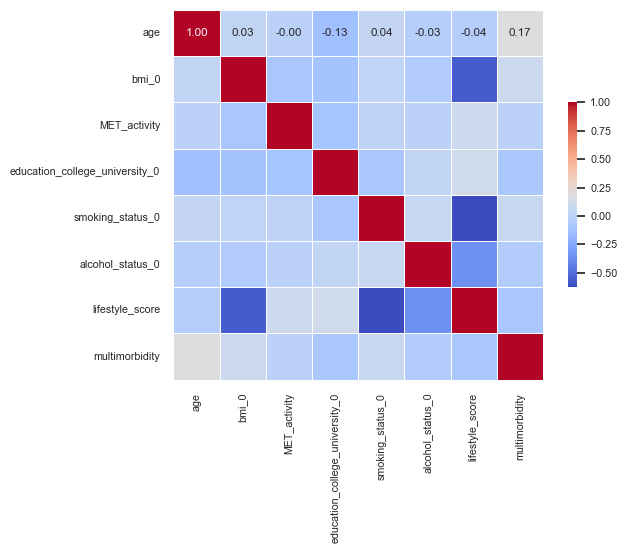

In [59]:
sb.heatmap(correlation_matrix,annot=True,fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Conclusion for EDA**
From the all the tests above, we get the gender, age, BMI are highly significant to the presence/absence of multimorbidity and MET, smoking status, and alcohol status are ,however, surprisingly not significant impact to the multimorbidity.

## Logistic Regression

In [38]:
dt_final['sex_encoded']=dt_final['sex'].map({'F':0,'M':1})

In [40]:
dt_final['multimorbidity_pre_abs']=dt_final['multimorbidity_pre_abs'].astype(int)
outcome=dt_final['multimorbidity_pre_abs']
predictors=dt_final[['age','sex_encoded','bmi_0','MET_activity','smoking_status_0','alcohol_status_0']]
predictors=sm.add_constant(predictors)

model_res=sm.OLS(outcome,predictors).fit()
print(model_res.summary())

                              OLS Regression Results                              
Dep. Variable:     multimorbidity_pre_abs   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                  0.009
Method:                     Least Squares   F-statistic:                     15.86
Date:                    Thu, 15 Feb 2024   Prob (F-statistic):           3.15e-18
Time:                            11:15:57   Log-Likelihood:                 9567.2
No. Observations:                   10000   AIC:                        -1.912e+04
Df Residuals:                        9993   BIC:                        -1.907e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


From the Logistic Regression result, we can find **age**, **bmi**, **gender**, and **alcohol_status** are the statistically significant features. Given the the R-sqaure and Adj. R-squared score, however, are extreme low, indicating that these features can explain very low variability of presence/absence of Multimorbidity. This required more reevaluation and next we add the lifestyle factor into the model and see what's the impact on the result.

In [41]:
predictors=dt_final[['age','sex_encoded','bmi_0','MET_activity','smoking_status_0','alcohol_status_0','lifestyle_score']]
predictors=sm.add_constant(predictors)

model_res=sm.OLS(outcome,predictors).fit()
print(model_res.summary())

                              OLS Regression Results                              
Dep. Variable:     multimorbidity_pre_abs   R-squared:                       0.010
Model:                                OLS   Adj. R-squared:                  0.009
Method:                     Least Squares   F-statistic:                     14.65
Date:                    Thu, 15 Feb 2024   Prob (F-statistic):           4.09e-19
Time:                            11:16:02   Log-Likelihood:                 9570.9
No. Observations:                   10000   AIC:                        -1.913e+04
Df Residuals:                        9992   BIC:                        -1.907e+04
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


In [42]:
X = dt_final[['lifestyle_score']] 
y = dt_final['multimorbidity_pre_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1982
           1       0.00      0.00      0.00        18

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.98      0.99      0.99      2000

[[1982    0]
 [  18    0]]


In [43]:
X = dt_final[['bmi_0','sex_encoded','lifestyle_score', 'MET_activity', 'smoking_status_0', 'alcohol_status_0']] 
y = dt_final['multimorbidity_pre_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1982
           1       0.00      0.00      0.00        18

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.98      0.99      0.99      2000

[[1982    0]
 [  18    0]]


From the EDA and model above, we can find several factors that might be significant impact on the presence and absence of multimorbidity. However, I think due to lack of multimorbidity sample in this dataset, it's hard to build a effective model to predict.

**The answer statement** for the project research question:

1. How do composite lifestyle factors such as smoking, alcohol consumption, and physical activity influence the risk of multimorbidity, specifically the co-occurrence of dementia, myocardial infarction (MI), and stroke in adults?

- From the result of the research above, we find that, for lifestyle factor,   only the alcohol status is the factor that might have impact on multimorbidity and others like MET and smoking status don't have. However, due to the reason that this dataset lack of multimorbidity cases, I don't think this could be the sources to support clinical diagnosis.

2. Is there an association between the accumulation of unhealthy lifestyle factors and an increased likelihood of multimorbidity?

- From the result of Logistic Regression model, we can tell there might be some impact that unhealthy bring increased likelihood to multiborbidity.

Okay so now we have imbalance dataset to be solved. After several researches, some methods to solve this situations:

1. Resample

2. SMOTE (Finind hard time to import imblearn pacakge)

3. Penalized

The code below is to perform them one by one and see the result of them on if they can make impact or not.

In [44]:
# Resampling
from sklearn.utils import resample
dt_majority=dt_final[dt_final['multimorbidity_pre_abs']==0]
dt_minority=dt_final[dt_final['multimorbidity_pre_abs']==1]
dt_minority_resample=resample(dt_minority,replace=True,n_samples=len(dt_majority),random_state=42)
dt_resample=pd.concat([dt_majority,dt_minority_resample])
dt_resample['multimorbidity_pre_abs'].value_counts()

multimorbidity_pre_abs
0    9912
1    9912
Name: count, dtype: int64

In [45]:
X = dt_resample[['lifestyle_score']] 
y = dt_resample['multimorbidity_pre_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
logreg=LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57      1996
           1       0.58      0.64      0.61      1969

    accuracy                           0.59      3965
   macro avg       0.59      0.59      0.59      3965
weighted avg       0.59      0.59      0.59      3965

[[1080  916]
 [ 704 1265]]


In [46]:
outcome=dt_resample['multimorbidity_pre_abs']
predictors=dt_resample[['age','sex_encoded','bmi_0','MET_activity','smoking_status_0','alcohol_status_0','lifestyle_score']]
predictors=sm.add_constant(predictors)

model_res=sm.OLS(outcome,predictors).fit()
print(model_res.summary())

                              OLS Regression Results                              
Dep. Variable:     multimorbidity_pre_abs   R-squared:                       0.284
Model:                                OLS   Adj. R-squared:                  0.283
Method:                     Least Squares   F-statistic:                     1121.
Date:                    Thu, 15 Feb 2024   Prob (F-statistic):               0.00
Time:                            11:16:17   Log-Likelihood:                -11082.
No. Observations:                   19824   AIC:                         2.218e+04
Df Residuals:                       19816   BIC:                         2.224e+04
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


In [47]:
X = dt_resample[['age','sex_encoded','lifestyle_score', 'smoking_status_0', 'alcohol_status_0']] 
y = dt_resample['multimorbidity_pre_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1996
           1       0.71      0.77      0.74      1969

    accuracy                           0.73      3965
   macro avg       0.73      0.73      0.73      3965
weighted avg       0.73      0.73      0.73      3965

[[1383  613]
 [ 453 1516]]


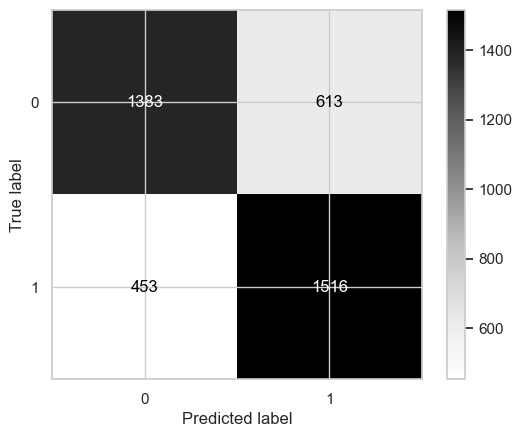

In [48]:
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greys')

This method use resample to address initial imbalance dataset issue. To be more specific, I upsampled the minority( Multimorbidity event) to match the size of majority (absence of multimorbidity) to create a balanced dataset for model training and evaluation.
The result shows that after addressing imbalance through resampling, the model demonstrated a balanced performance across precision, recall, and F1-score metrics. The accuracy of 73% indicates a moderately effective model for predicting multimorbidity presence or absence, considering the complex nature of multimorbidity and the limitations of using a relatively small set of predictors.

In [60]:
#Penalized 
X = dt_final[['age','sex_encoded','lifestyle_score', 'smoking_status_0', 'alcohol_status_0']] 
y = dt_final['multimorbidity_pre_abs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
logreg=LogisticRegression(class_weight='balanced',solver='liblinear')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1982
           1       0.02      0.83      0.05        18

    accuracy                           0.69      2000
   macro avg       0.51      0.76      0.43      2000
weighted avg       0.99      0.69      0.81      2000

[[1375  607]
 [   3   15]]


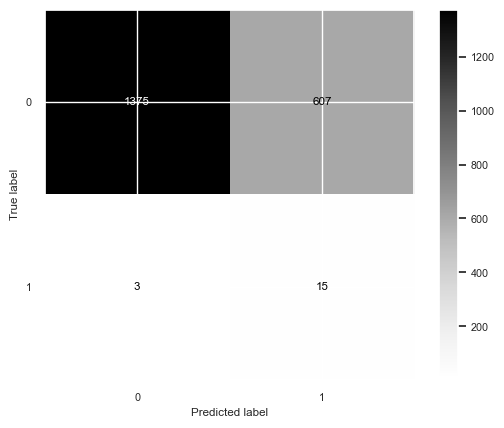

In [61]:
cm=confusion_matrix(y_test, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greys')

I perform penalized technique by adding class_weight='balance' and utilized the model with 'liblinear' solver, which is better for the small sized dataset and binary outcome predicting.
After adding penalized technique into the model, the logistic predicting model actually also demonstrated a nice ability to identify the people with multimorbidity, proven by the high recall rate. However the precision of the model is very low, which in a simple term when the model predicts it yes, there's only 2% of the yes predicted result is correct and meaning the model is catching too much people that actually don't have multimorbidity but announced as having multimorbidity. This kinda trade-off is not going to be appropriated in healthcare case, specially this case is to find patient with multimorbidity and this method could cause lots unnecessary exam further panic to patients.

Overall, I'd still recommend to collect more data to expand more cases with multimorbidity that can improve the performance of the model.